In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy.signal import get_window
import glob
import time

def plot_scatter_func(x, y, label, title, xlab, ylab, x1 = None, x2 = None, y1 = None, y2 = None):

    f, ax = plt.subplots(figsize = (20, 10))
    ax.scatter(x, y, label = label)
    ax.set_title(title, fontsize = 30)
    ax.set_xlabel(xlab, fontsize = 30)
    ax.set_ylabel(ylab, fontsize = 30)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.set_xlim(x1, x2)
    ax.set_ylim(y1, y2)
    ax.legend(loc = 'best', fontsize = 20)
    ax.grid(True)

    return f

def phase_func(Y):
    phases = np.angle(Y) * 180 / np.pi
    
    return phases

#dBu = 20log10(V/0.775V)

#Why the windowing? The FFT assumes that the signal is periodic and continuous within the window. 
#If the signal is not perfectly periodic, it can cause spectral leakage, which results in an offset or differences in the frequency spectrum.

def rfft(y, cnv): #this function computes the fft of y
    #window = get_window("hanning", len(y))
    #window = 1
    #y_windowed = y * window
    if np.isnan(y).any():
        nan_indices = np.where(np.isin(y))[0]
        print(f"Input data contains NaN values in {nan_indices}.")
        
    if np.isinf(y).any():
        print("Input data contains Inf values.")
        
    N = len(y)
    Y = fft.rfft(y)
    phases = phase_func(Y)
    Y_normalized = np.abs(Y) / N
    Y_dBu = 20*(np.log10(np.abs(Y_normalized)  * cnv / 0.775 ))
        
    return Y_dBu, phases

In [2]:
hour = '15.42'
day = '08082024'

# With low-pass filter

In [3]:
file_pattern_w = f"../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list_w = glob.glob(file_pattern_w)

amplitudes_list = []

if not file_list_w:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list_w):
        df = pd.read_csv(file)
        if i == 0:
            print(df.iloc[:, 0])
            print(df.iloc[:, 1])
            times_w = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
        amplitudes_w = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        amplitudes_list.append(amplitudes_w)
            
all_amplitudes_w = np.stack(amplitudes_list, axis = 0)
print(all_amplitudes_w)


0               (us)
1         0.00000000
2         0.00080000
3         0.00160000
4         0.00240000
            ...     
62500    49.99920067
62501    50.00000067
62502    50.00080067
62503    50.00160067
62504    50.00240067
Name: Time, Length: 62505, dtype: object
0               (mV)
1        -1.96850400
2        -1.57480300
3        -1.18110200
4        -0.78740150
            ...     
62500     0.00000000
62501     0.39370070
62502    -0.39370070
62503    -1.18110200
62504    -1.18110200
Name: Channel D, Length: 62505, dtype: object
[[-1.968504  -1.574803  -1.181102  ... -0.3937007 -1.181102  -1.181102 ]
 [ 1.574803   0.7874015  0.        ... -0.3937007 -2.755905  -4.724409 ]
 [-0.3937007 -0.3937007  0.3937007 ... -0.7874015 -2.362205  -3.149606 ]
 ...
 [-3.149606  -2.755905  -1.181102  ...  3.149606   3.149606   2.755905 ]
 [ 1.574803   1.574803   1.574803  ...  3.149606   3.149606   1.574803 ]
 [ 1.181102   1.574803   2.755905  ...  2.755905   1.968504   2.362205 ]]


In [4]:
conversion_factor = 0.001

### compute the FFTs

In [5]:
Ys_dBu_list = []
phases_list = []

for i in range(all_amplitudes_w.shape[0]):
    Y_dBu_w, phase_w = rfft(all_amplitudes_w[i, :], conversion_factor)
    Ys_dBu_list.append(Y_dBu_w)
    phases_list.append(phase_w)

Ys_dBu_w = np.stack(Ys_dBu_list, axis = 0)
phases_w = np.stack(phases_list, axis = 0)
print(f"Ys_dBu_w: {Ys_dBu_w}")
print(f"phases_w: {phases_w}")

Ys_dBu_w: [[ -75.4179109  -119.67602609 -114.48453554 ... -123.22049893
  -133.29349171 -137.7186307 ]
 [ -75.26513911 -111.98116171 -109.08545202 ... -126.44329094
  -124.89024081 -112.98268713]
 [ -74.96545032 -114.4874119  -115.65302792 ... -122.8175642
  -111.51638347 -124.77570792]
 ...
 [ -76.8012532  -106.04388115 -111.7850067  ... -118.0810417
  -123.83888582 -130.67482804]
 [ -75.34862438 -110.26393977 -121.17210378 ... -123.7196158
  -116.33779937 -152.2587915 ]
 [ -75.94157428 -119.48933894 -121.77581099 ... -117.93544833
  -114.19139495 -116.79246666]]
phases_w: [[   0.           30.58505873 -106.00456808 ...   20.80796059
   152.0386812     0.        ]
 [   0.           59.12909604   26.7586038  ... -156.72673235
   129.00731463    0.        ]
 [   0.           16.9382454   -47.28961186 ...  -45.9525749
   -75.7087818     0.        ]
 ...
 [   0.           32.56117444  -14.40391155 ... -118.54678591
  -122.85710417  180.        ]
 [   0.          -12.41754001  -36.34429803

### compute and plot the average fft and the average of their phases

In [6]:
span_w = times_w[len(times_w)-1] 
f_s_w = len(times_w) / span_w
print(f"f_s_avg_fft = {f_s_w}")
freqs_w = fft.rfftfreq(all_amplitudes_w.shape[1], 1/f_s_w) #window lenght, sample spacing

avg_fft_dBu_w = np.mean(Ys_dBu_w, axis = 0)
avg_phases_w = np.mean(phases_w, axis = 0)
print(f"avg_fft_dBu_w: {avg_fft_dBu_w}")
print(f"avg_phases_w: {avg_phases_w}")


f_s_avg_fft = 1250.0199822905822
avg_fft_dBu_w: [ -75.0912905  -113.25471028 -114.90989648 ... -121.18955648 -122.31247894
 -121.4373383 ]
avg_phases_w: [  0.          12.04390863  -2.41214908 ...   0.02600033 -11.75326485
  16.875     ]


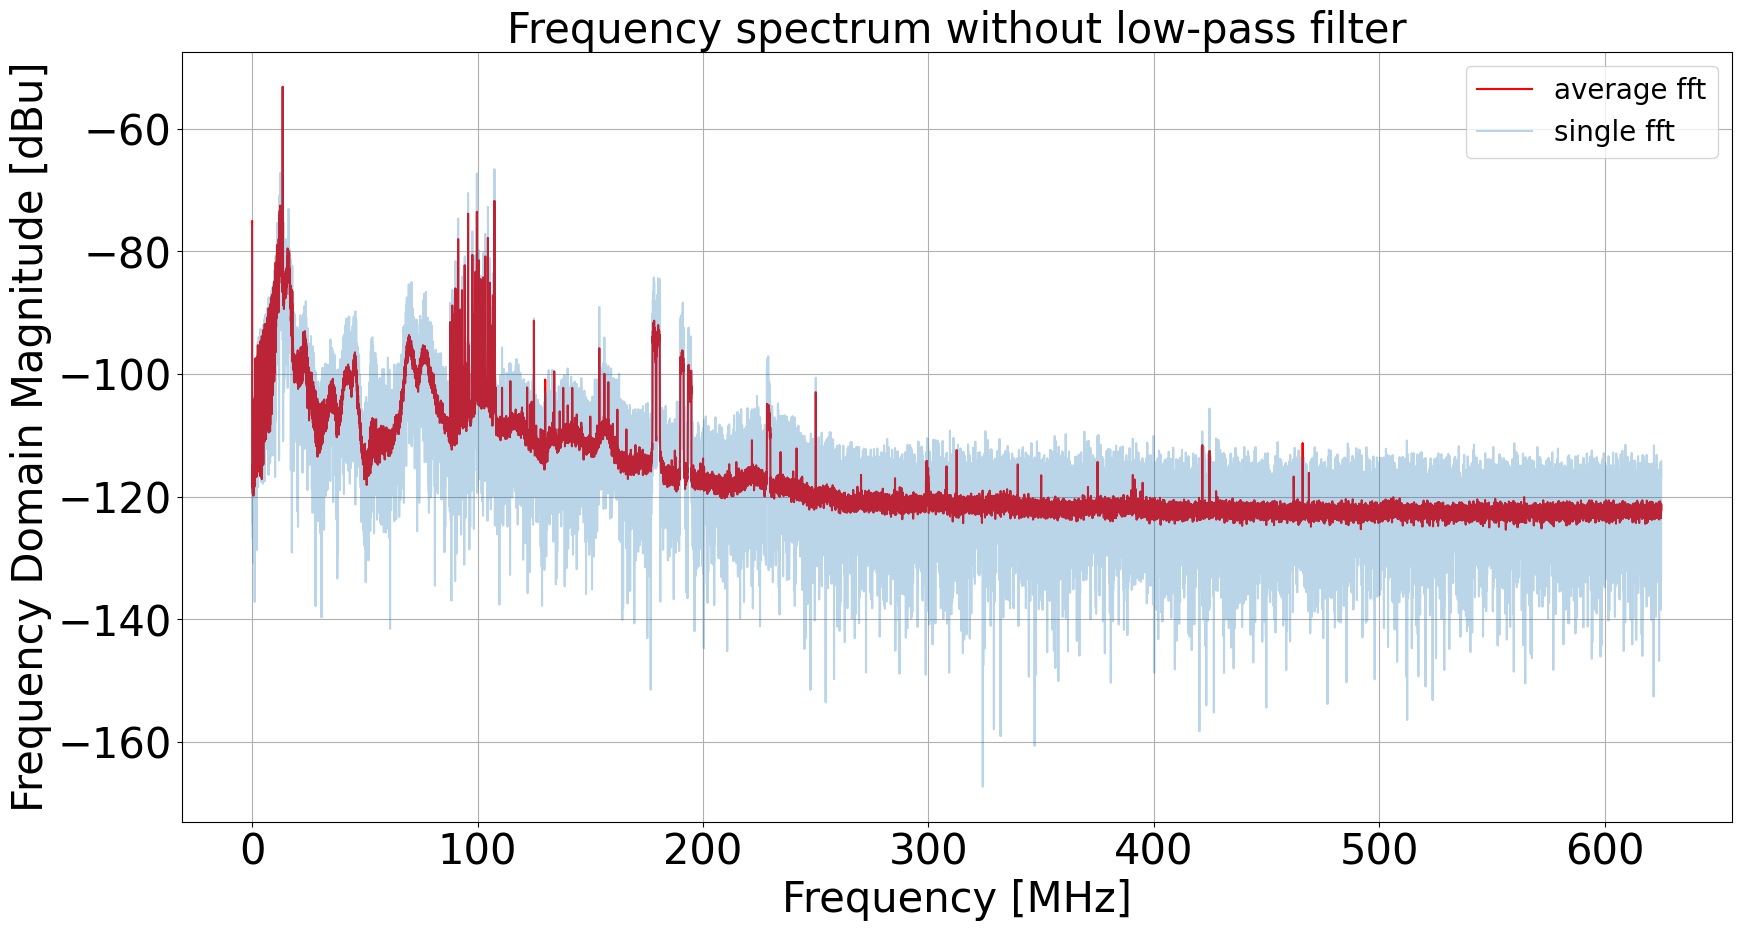

In [7]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs_B, avg_fft_dBu, yerr = stds_fft_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs_w, avg_fft_dBu_w, color = 'red', label = 'average fft')
plt.plot(freqs_w, Y_dBu_w, alpha = 0.3, label = 'single fft')
plt.title('Frequency spectrum without low-pass filter', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.legend(fontsize = 20)
#plt.semilogx()

plt.savefig("080824_15.42/fft_w_lowpass.png", format = "png", bbox_inches="tight")
plt.savefig("080824_15.42/fft_w_lowpass.pdf", format = "pdf", bbox_inches="tight")

plt.show()


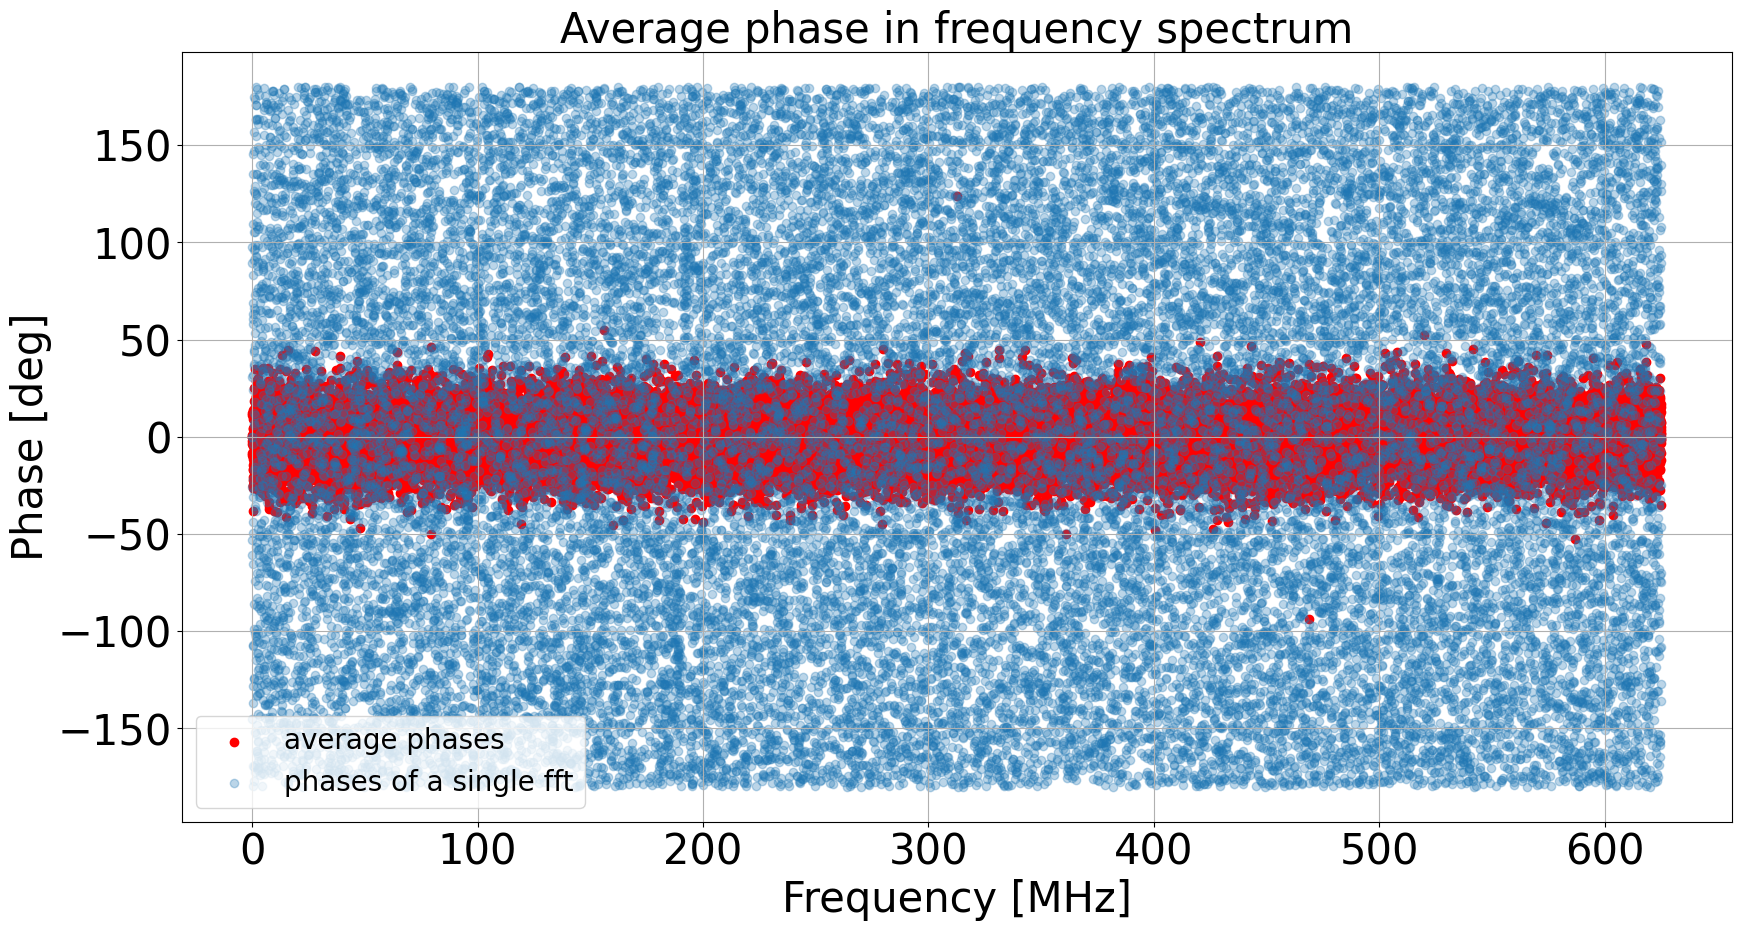

In [8]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs_B, phases_avg, yerr = phases_err_avg, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.scatter(freqs_w, avg_phases_w, color = 'red', label = 'average phases')
plt.scatter(freqs_w, phase_w, alpha = 0.3, label = 'phases of a single fft')
plt.title('Average phase in frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Phase [deg]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.legend(fontsize = 20, loc = 'best')
#plt.semilogx()

#plt.savefig("080824_14.24/avg_phases_B.png", format = "png", bbox_inches="tight")
#plt.savefig("080824_14.24/avg_phases_B.pdf", format = "pdf", bbox_inches="tight")

plt.show()


In [9]:
hour = '16.07'
day = '08082024'

# Without low-pass filter

In [10]:
file_pattern_wo = f"../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list_wo = glob.glob(file_pattern_wo)

amplitudes_list_wo = []

if not file_list_wo:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list_wo):
        df = pd.read_csv(file)
        if i == 0:
            print(df.iloc[:, 0])
            print(df.iloc[:, 1])
            times_wo = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
        amplitudes_wo = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        amplitudes_list_wo.append(amplitudes_wo)
            
all_amplitudes_wo = np.stack(amplitudes_list_wo, axis = 0)
print(all_amplitudes_wo)

0               (us)
1         0.00000000
2         0.00080000
3         0.00160000
4         0.00240000
            ...     
62500    49.99920067
62501    50.00000067
62502    50.00080067
62503    50.00160067
62504    50.00240067
Name: Time, Length: 62505, dtype: object
0               (mV)
1        -2.36220500
2        -2.36220500
3        -2.36220500
4        -1.57480300
            ...     
62500     1.18110200
62501     0.78740150
62502     0.39370070
62503     1.18110200
62504     1.96850400
Name: Channel D, Length: 62505, dtype: object
[[-2.362205  -2.362205  -2.362205  ...  0.3937007  1.181102   1.968504 ]
 [ 2.362205   2.362205   2.755905  ...  5.511811   5.11811    3.937008 ]
 [ 6.299212   6.692913   6.692913  ...  7.874015   7.480314   6.299212 ]
 ...
 [ 3.149606   2.362205   1.574803  ...  4.330709   3.937008   4.330709 ]
 [ 5.511811   6.692913   7.480314  ...  2.362205   2.362205   2.755905 ]
 [ 3.937008   7.086614   8.267716  ... -2.362205  -1.574803  -0.3937007]]


In [11]:
conversion_factor = 0.001

### compute the FFTs

In [12]:
Ys_dBu_list = []
phases_list = []

for i in range(all_amplitudes_wo.shape[0]):
    Y_dBu_wo, phase_wo = rfft(all_amplitudes_wo[i, :], conversion_factor)
    Ys_dBu_list.append(Y_dBu_wo)
    phases_list.append(phase_wo)

Ys_dBu_wo = np.stack(Ys_dBu_list, axis = 0)
phases_wo = np.stack(phases_list, axis = 0)
print(f"Ys_dBu_B_wo: {Ys_dBu_wo}")
print(f"phases_B_wo: {phases_wo}")

Ys_dBu_B_wo: [[ -81.90133205 -110.8280775  -115.11234087 ... -120.62264693
  -123.4628036  -123.84832354]
 [ -84.37758226 -110.06571531 -109.4622098  ... -121.91711378
  -115.77638364 -118.33712368]
 [ -84.13218066 -131.74781625 -120.96400093 ... -115.11794788
  -120.52481722 -106.77528395]
 ...
 [ -82.37256484 -119.03294896 -114.12338698 ... -124.74727464
  -119.92215717 -112.82673596]
 [ -81.07707385 -119.24590345 -110.9697898  ... -123.01949969
  -116.75082387 -121.54411283]
 [ -84.72811787 -116.49297869 -118.37835248 ... -125.91102018
  -116.57412145 -132.55291769]]
phases_B_wo: [[   0.           73.5636243    85.49593685 ... -130.416202
   129.54831882    0.        ]
 [   0.           10.3261234    51.61667806 ...  -39.24763878
    95.36032641  180.        ]
 [   0.          -33.72775453 -176.15000517 ...   55.45162428
   123.27285647    0.        ]
 ...
 [   0.          175.23993653  -11.65999141 ...  157.72006213
  -116.47486106    0.        ]
 [   0.          -51.17532776  -69.

### compute and plot the average fft and the average of their phases

In [14]:
span_wo = times_wo[len(times_wo)-1] 
f_s_wo = len(times_wo) / span_wo
print(f"f_s_wo = {f_s_wo}")
freqs_wo = fft.rfftfreq(all_amplitudes_wo.shape[1], 1/f_s_wo) #window lenght, sample spacing

avg_fft_dBu_wo = np.mean(Ys_dBu_wo, axis = 0)
avg_phases_wo = np.mean(phases_wo, axis = 0)
print(f"avg_fft_dBu_wo: {avg_fft_dBu_wo}")
print(f"avg_phases_wo: {avg_phases_wo}")


f_s_wo = 1250.0199822905822
avg_fft_dBu_wo: [ -82.7658488  -113.73603207 -116.11800061 ... -120.72050319 -120.37200863
 -119.78835029]
avg_phases_wo: [  0.          22.65026523  -4.82348132 ... -22.41007384 -16.52554765
  39.375     ]


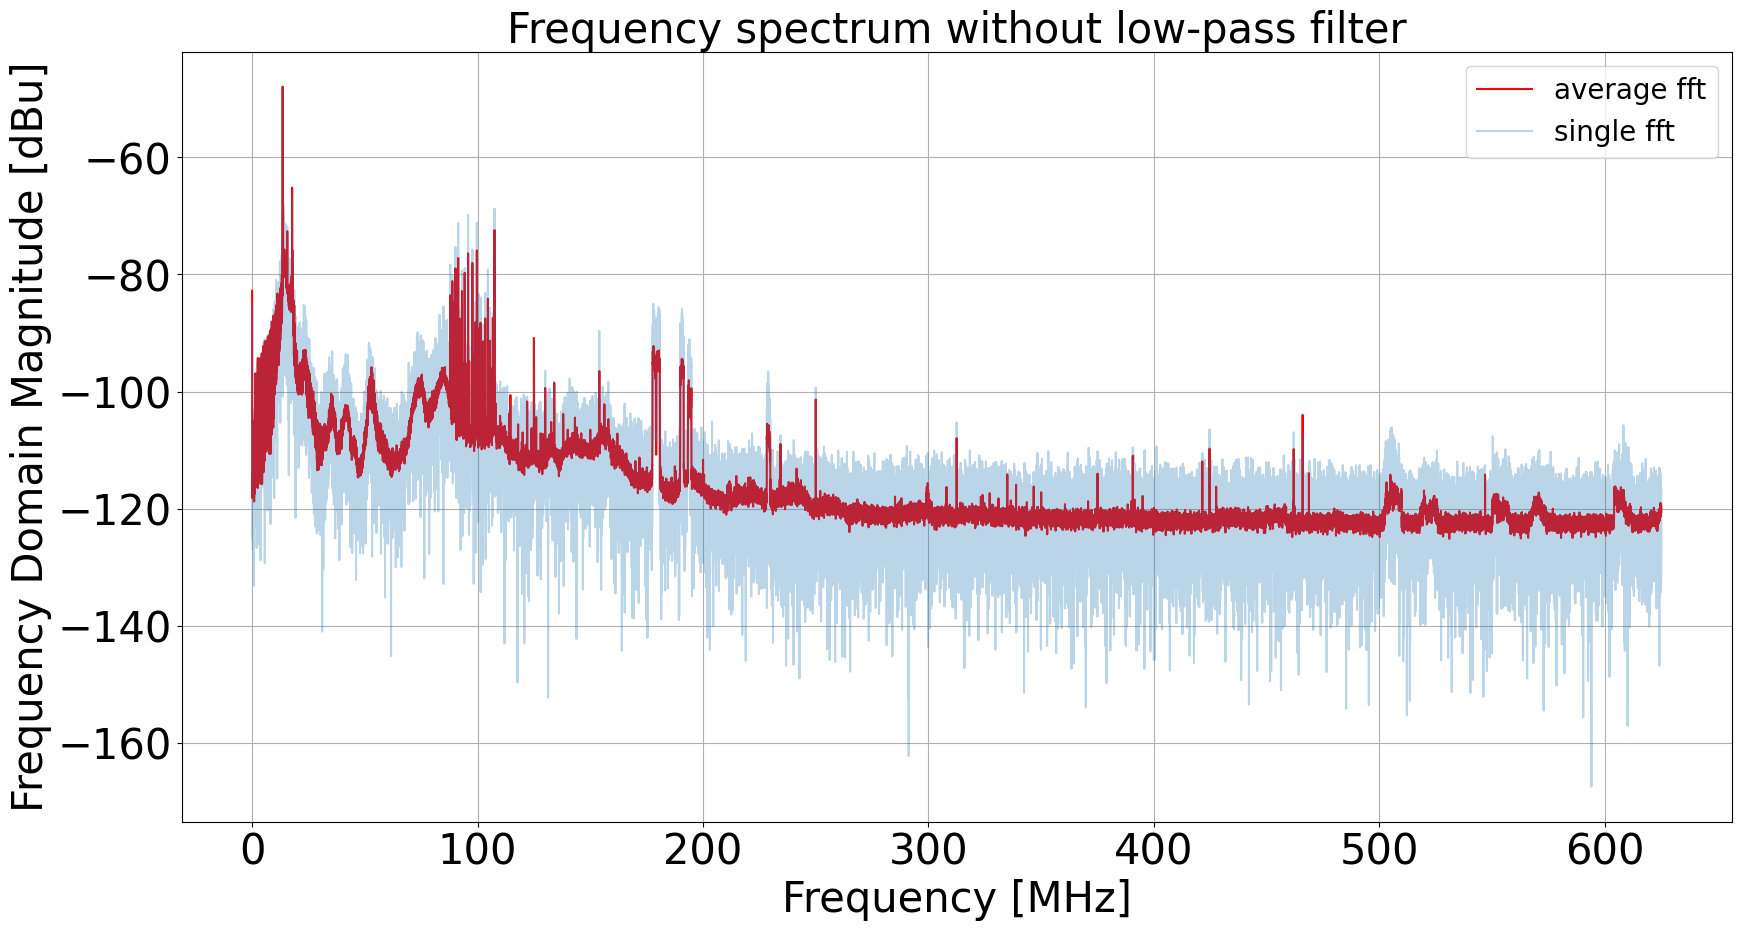

In [15]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs_B, avg_fft_dBu, yerr = stds_fft_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs_wo, avg_fft_dBu_wo, color = 'red', label = 'average fft')
plt.plot(freqs_wo, Y_dBu_wo, alpha = 0.3, label = 'single fft')
plt.title('Frequency spectrum without low-pass filter', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.legend(fontsize = 20)
#plt.semilogx()

plt.savefig("080824_15.42/fft_w_lowpass.png", format = "png", bbox_inches="tight")
plt.savefig("080824_15.42/fft_w_lowpass.pdf", format = "pdf", bbox_inches="tight")

plt.show()


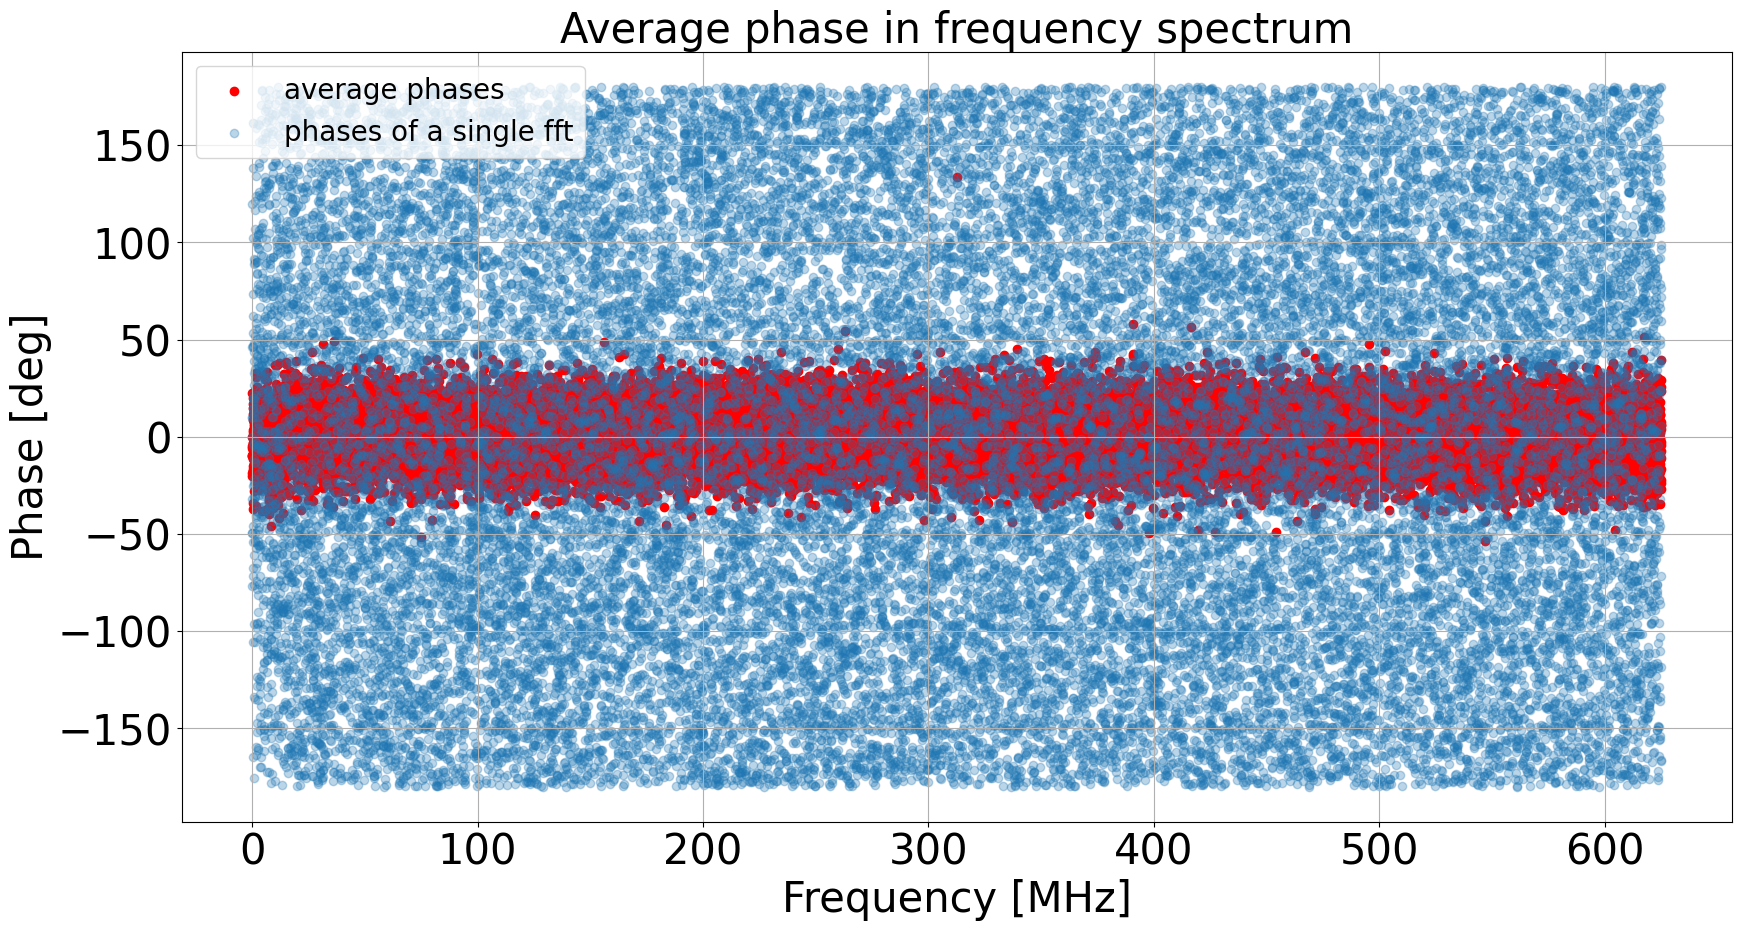

In [16]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs_B, phases_avg, yerr = phases_err_avg, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.scatter(freqs_wo, avg_phases_wo, color = 'red', label = 'average phases')
plt.scatter(freqs_wo, phase_wo, alpha = 0.3, label = 'phases of a single fft')
plt.title('Average phase in frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Phase [deg]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.legend(fontsize = 20, loc = 'best')
#plt.semilogx()

#plt.savefig("080824_14.24/avg_phases_B.png", format = "png", bbox_inches="tight")
#plt.savefig("080824_14.24/avg_phases_B.pdf", format = "pdf", bbox_inches="tight")

plt.show()


# Comparison between the two set-ups

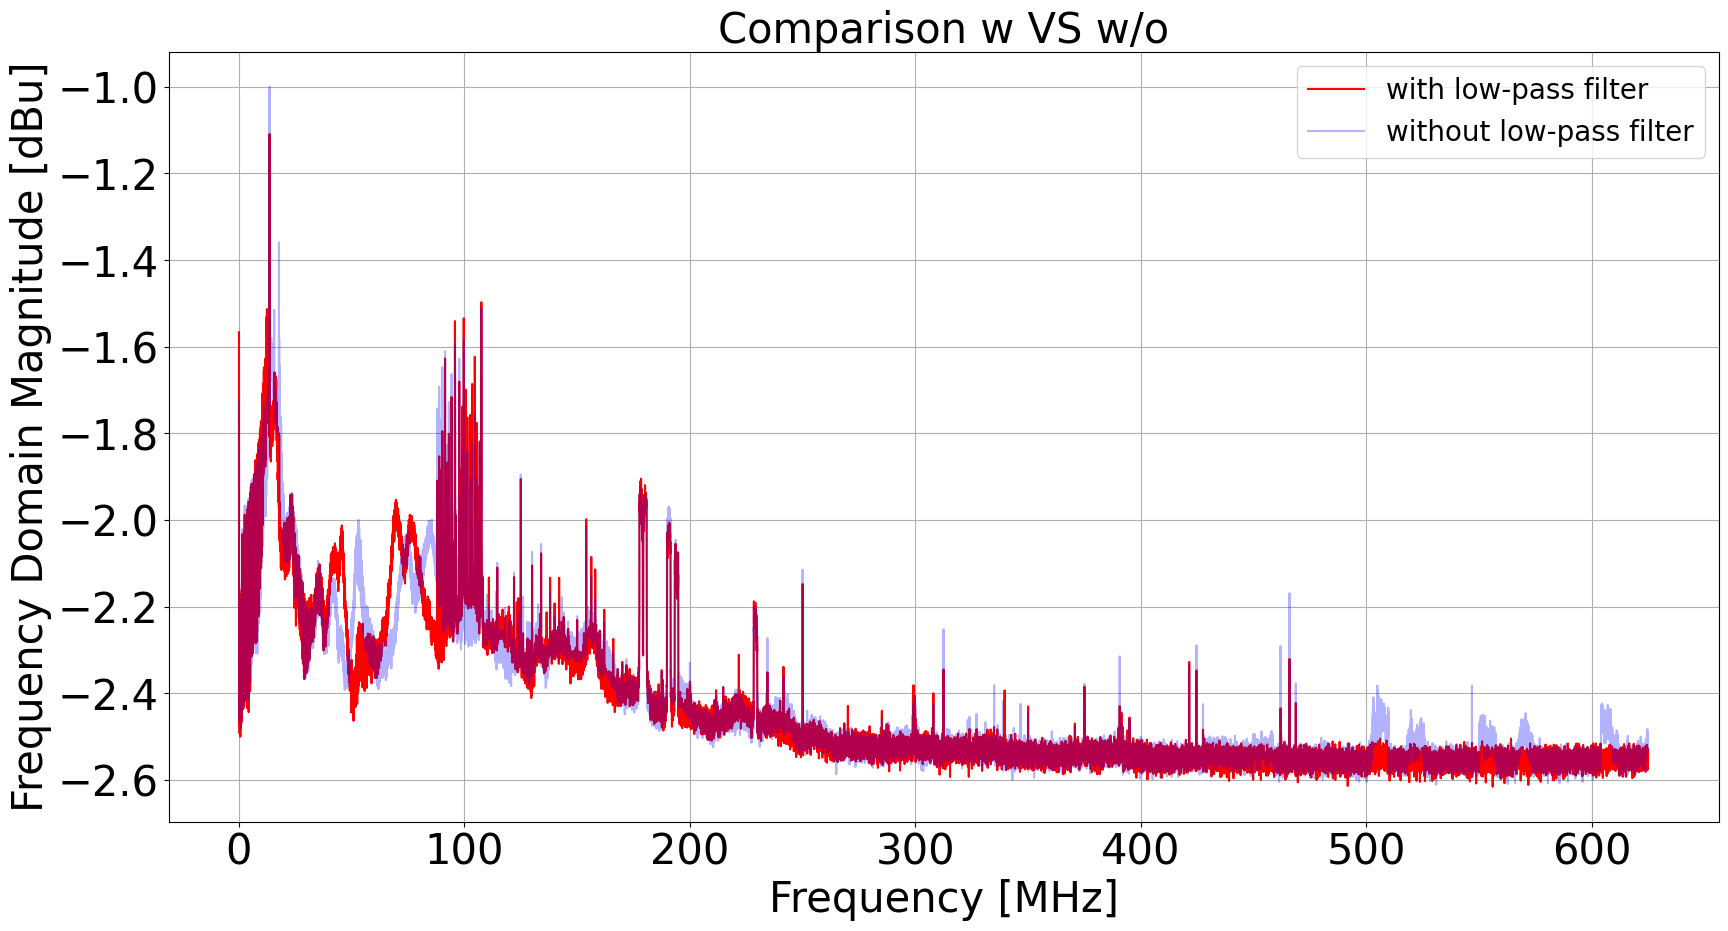

In [17]:
#normalization
n1 = np.max(avg_fft_dBu_w)
n2 = np.max(avg_fft_dBu_wo)
n = -max(n1, n2)

plt.figure(figsize=(20, 10))
#plt.errorbar(freqs_B, avg_fft_dBu, yerr = stds_fft_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)

plt.plot(freqs_w, avg_fft_dBu_w/n, color = 'red', label = 'with low-pass filter')
plt.plot(freqs_wo, avg_fft_dBu_wo/n, alpha = 0.3, color = 'blue', label = 'without low-pass filter')

plt.title('Comparison w VS w/o', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.legend(fontsize = 20)
#plt.semilogx()

plt.savefig("080824_15.42/w_vs_wo.png", format = "png", bbox_inches="tight")
plt.savefig("080824_15.42/w_vs_wo.pdf", format = "pdf", bbox_inches="tight")

plt.show()